In [822]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, CLA, risk_models, expected_returns, plotting

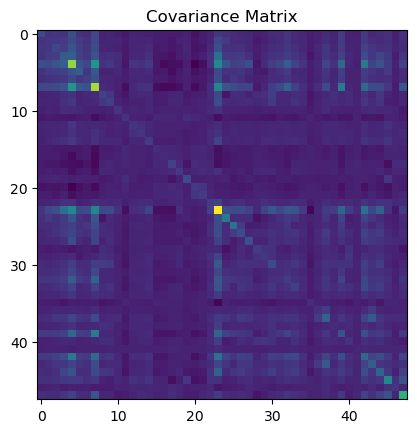

(AAPL     0.180925
 MSFT     0.062780
 GOOGL   -0.061376
 AMZN     0.064652
 TSLA     0.383629
 META     0.173195
 NFLX     0.111283
 NVDA     0.025128
 JPM      0.048688
 BAC      0.037780
 WMT      0.189037
 PG       0.048112
 V        0.057075
 MA       0.114060
 DIS     -0.086493
 PEP      0.035903
 KO       0.138660
 UNH      0.169132
 PFE      0.026223
 MRK     -0.075531
 T        0.203809
 VZ       0.089778
 CSCO     0.112126
 INTC    -0.297653
 ORCL     0.408980
 ADBE     0.199125
 CRM      0.127640
 BABA     0.160631
 XOM      0.021703
 CVX     -0.068889
 GS       0.113918
 SPY      0.085301
 QQQ      0.068409
 IWM      0.097675
 DIA      0.094899
 TLT      0.094244
 GLD      0.101050
 SLV      0.007171
 XLF      0.108528
 XLK      0.063232
 XLE     -0.011961
 XLV      0.081687
 ARKK     0.103304
 GDX      0.118558
 BA      -0.162432
 NKE     -0.138335
 MCD      0.137863
 SBUX     0.187691
 dtype: float64,
            AAPL      MSFT     GOOGL      AMZN      TSLA      META     

In [823]:
"""
start_date = '2022-06-01' # inclusive
end_date = '2024-09-20' # exclusive
"""

budget = 1000000  # Example total investment (you can change this value)

# Closing price data obtained from yfinance
# 2year_closing.csv
data = pd.read_csv("close.csv", parse_dates=True, index_col="Date")

returns_df = data.pct_change().dropna()

frequency=len(returns_df)
mu = expected_returns.mean_historical_return(data, frequency=frequency)
S = risk_models.sample_cov(data, frequency=frequency)

plt.imshow(S, interpolation="nearest")
plt.title("Covariance Matrix")
plt.show()

mu, S

This classical model maximizes the Sharpe ratio of a portfolio of 48 stocks.

PyPfOpt calculates the Sharpe ratio as $$S_R = \frac{\mu - \text{Risk-free rate}}{\sigma} = \frac{\mu - 0.02}{\sigma}$$

However, do also note that PyPfOpt calcluates <b>log returns</b>. This means the each return is $r_{i+1} = \log \left(1 + \frac{p_{i+1} - p_{i}}{p_{i}} \right)$ and the mean historical return is $\left[ \Pi_{i=2}^n \left( 1 + r_{i+1} \right) \right]^{n} - 1$. The covariance matrix is made with log returns, <u>then multiplied by $n$.</u>

In [825]:
# Optimize using CLA for balanced risk

cla = CLA(mu, S)
cla.min_volatility()  # CLA used to minimize volatility first
# cla.max_sharpe()
cla_weights = cla.clean_weights()

# Step 2: Use the result from CLA as a starting point for EF
ef = EfficientFrontier(mu, S)
ef.set_weights(cla_weights)  # Set the weights from CLA as the starting point

# # Apply constraints if needed
ef.add_constraint(lambda w: w <= 0.1)  # Limit weights to 10% - only for high budget
ef.add_constraint(lambda w: w >= 0.005)  # Set a minimum weight

ef_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

In [826]:
# Calculate performance of the CLA model portfolio
performance = cla.portfolio_performance(verbose=True)

Expected annual return: 9.4%
Annual volatility: 3.7%
Sharpe Ratio: 2.01


In [827]:
# Get the latest stock prices from your data
latest_prices = data.iloc[-1]
#Calculate the number of shares (rounded down to whole shares)
weights_array = np.array(list(cleaned_weights.values()))
shares = np.floor(weights_array * budget / latest_prices)

# Calculate the new weights based on the actual total portfolio value
total_value = np.dot(shares, latest_prices)
new_weights = (shares * latest_prices) / total_value
ef.set_weights(dict(zip(data.columns, new_weights)))

print('\nPerformance of ef optmized portfolio')
performance = ef.portfolio_performance(verbose=True)


Performance of ef optmized portfolio
Expected annual return: 16.6%
Annual volatility: 5.3%
Sharpe Ratio: 2.77


Since only a few months of data was used, this high result is expected

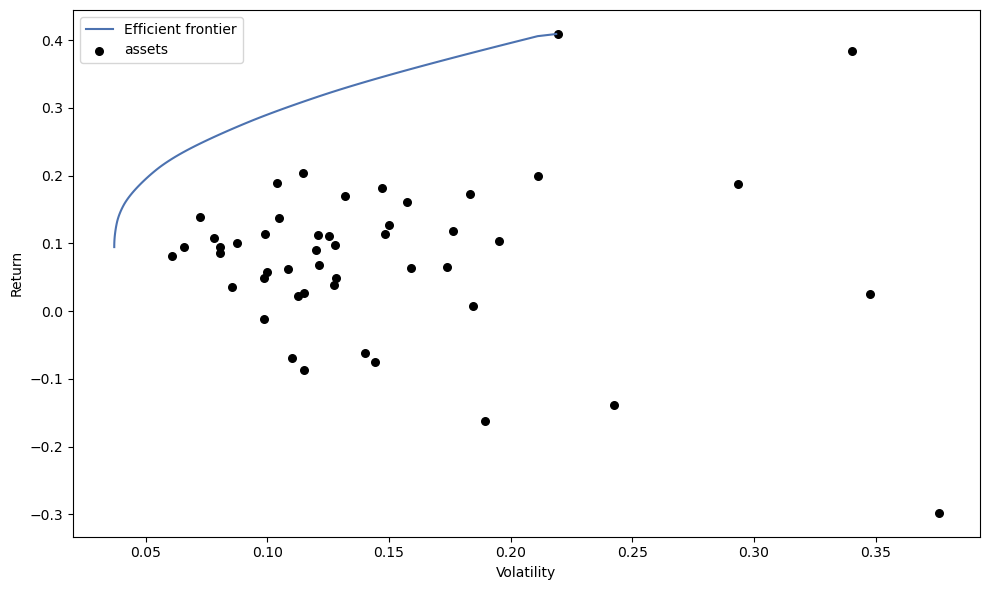

In [829]:
# Create a new EfficientFrontier instance for plotting
ef_for_plotting = EfficientFrontier(mu, S)

# Plot Efficient Frontier (Risk vs Return) and show the black dots (assets)
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=True)

# handles, labels = ax.get_legend_handles_labels()
# labels = [label.replace("assets", "Portfolios") for label in labels]

ax.legend(handles, labels)
plt.show()

In [830]:
expected_return, volatility, sharpe_ratio = ef.portfolio_performance()


print("Optimal number of shares of each stock:\n", shares, sep="")

total = round(sum(latest_prices * shares), 2)
print("\nTotal initial spending:", total, "dollars")
print("Expected portfolio value after 1 yr:", round(total * (1+expected_return), 2), "dollars")

Optimal number of shares of each stock:
AAPL      337.0
MSFT       11.0
GOOGL      30.0
AMZN       26.0
TSLA       20.0
META       39.0
NFLX        7.0
NVDA       42.0
JPM        23.0
BAC       122.0
WMT      1281.0
PG         29.0
V          17.0
MA         10.0
DIS        53.0
PEP        28.0
KO       1416.0
UNH       173.0
PFE       168.0
MRK        42.0
T        4681.0
VZ        113.0
CSCO       97.0
INTC      236.0
ORCL      596.0
ADBE       66.0
CRM        18.0
BABA      421.0
XOM        43.0
CVX        34.0
GS          9.0
SPY         8.0
QQQ        10.0
IWM        22.0
DIA        11.0
TLT      1007.0
GLD        20.0
SLV       177.0
XLF       109.0
XLK        22.0
XLE        56.0
XLV        32.0
ARKK      105.0
GDX       125.0
BA         32.0
NKE        61.0
MCD       146.0
SBUX       51.0
Name: 2024-09-19 00:00:00-04:00, dtype: float64

Total initial spending: 994572.99 dollars
Expected portfolio value after 1 yr: 1159606.33 dollars
